In [1]:
import gc
gc.collect()

37

In [2]:
clear

In [1]:
import os
import numpy as np
import nibabel as nib
from nilearn.masking import apply_mask
from nilearn.image import index_img
import gc
import requests
import time
from nilearn.image import resample_to_img

# === Configuration ===
subj = 1
session = 1
subj_str = f"subj{subj:02d}"
session_str = f"session{session:02d}"
output_dir = '/home/jovyan/cache/memoryNSD/'
pfc_mask_dir = os.path.join(output_dir, 'pfc_masks')
tmp_dir = '/tmp'

# Create output directory if needed
os.makedirs(output_dir, exist_ok=True)

# === File paths ===
beta_url = f"https://natural-scenes-dataset.s3.amazonaws.com/nsddata_betas/ppdata/{subj_str}/func1mm/betas_fithrf_GLMdenoise_RR/betas_{session_str}.nii.gz"
mtl_url = f"https://natural-scenes-dataset.s3.amazonaws.com/nsddata/ppdata/{subj_str}/func1mm/roi/MTL.nii.gz"
beta_local_path = os.path.join(tmp_dir, f"{subj_str}_{session_str}.nii.gz")
mtl_mask_path = os.path.join(tmp_dir, f"{subj_str}_MTL.nii.gz")
pfc_mask_path = os.path.join(pfc_mask_dir, f"{subj_str}_DLPFCmask.nii.gz")

# === Download helper ===
def download_if_needed(url, local_path):
    if not os.path.exists(local_path):
        print(f"Downloading: {url}")
        with requests.get(url, stream=True) as r:
            r.raise_for_status()
            with open(local_path, 'wb') as f:
                for chunk in r.iter_content(chunk_size=8192):
                    f.write(chunk)
        print(f"Saved to: {local_path}")

# === Download needed files ===
download_if_needed(beta_url, beta_local_path)
download_if_needed(mtl_url, mtl_mask_path)
assert os.path.exists(pfc_mask_path), f"Missing PFC mask: {pfc_mask_path}"

# === Load images ===
print("Loading images...")
beta_img = nib.load(beta_local_path)

# === Load and binarize MTL and PFC masks ===
mtl_raw = nib.load(mtl_mask_path)
pfc_raw = nib.load(pfc_mask_path)

# Convert any voxel > 0 to 1 (binary mask)
mtl_mask_data = (mtl_raw.get_fdata() > 0).astype(np.uint8)
pfc_mask_data = (pfc_raw.get_fdata() > 0).astype(np.uint8)

# Wrap back into Nifti images with the same affine
mtl_mask_img = nib.Nifti1Image(mtl_mask_data, affine=mtl_raw.affine)

# Create nifti from binary data using original affine
pfc_mask_nifti = nib.Nifti1Image(pfc_mask_data, affine=pfc_raw.affine)

# Resample PFC mask to beta image space (so affine and shape match)
pfc_mask_img = resample_to_img(pfc_mask_nifti, beta_img, interpolation='nearest')

n_trials = beta_img.shape[-1]
print(f"Found {n_trials} beta trials.")

# === Time benchmark ===
start_time = time.time()

# === Process each beta trial ===
for i in range(n_trials):
    print(f"Processing beta {i + 1}/{n_trials}...", end='\r')

    beta_i = index_img(beta_img, i)
    mtl_data = apply_mask(beta_i, mtl_mask_img)
    pfc_data = apply_mask(beta_i, pfc_mask_img)

    # Save output
    np.save(os.path.join(output_dir, f"{subj_str}_{session_str}_beta_{i:04d}_mtl.npy"), mtl_data)
    np.save(os.path.join(output_dir, f"{subj_str}_{session_str}_beta_{i:04d}_pfc.npy"), pfc_data)

    # Memory cleanup
    del beta_i, mtl_data, pfc_data
    gc.collect()

elapsed = time.time() - start_time
print(f"\n✅ Finished processing {subj_str} {session_str} in {elapsed:.2f} seconds.")

# Optional: Clean up temp files
os.remove(beta_local_path)
os.remove(mtl_mask_path)


Loading images...


/tmp/ipykernel_18684/1564123705.py:65: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  pfc_mask_img = resample_to_img(pfc_mask_nifti, beta_img, interpolation='nearest')
/srv/conda/envs/notebook/lib/python3.11/site-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


Found 750 beta trials.
Processing beta 750/750...
✅ Finished processing subj01 session01 in 530.61 seconds.


In [2]:
import requests
import os

subj = 1
session = 1
subj_str = f"subj{subj:02d}"
session_str = f"session{session:02d}"
tmp_dir = "/tmp"
beta_url = f"https://natural-scenes-dataset.s3.amazonaws.com/nsddata_betas/ppdata/{subj_str}/func1mm/betas_fithrf_GLMdenoise_RR/betas_{session_str}.nii.gz"
beta_path = os.path.join(tmp_dir, f"{subj_str}_{session_str}.nii.gz")

def download_file(url, local_path):
    if not os.path.exists(local_path):
        print(f"Downloading {url}")
        with requests.get(url, stream=True) as r:
            r.raise_for_status()
            with open(local_path, 'wb') as f:
                for chunk in r.iter_content(chunk_size=8192):
                    f.write(chunk)
        print(f"Downloaded to {local_path}")

download_file(beta_url, beta_path)


Downloaded to /tmp/subj01_session01.nii.gz


In [3]:
import nibabel as nib

output_dir = '/home/jovyan/cache/memoryNSD/'
pfc_mask_dir = os.path.join(output_dir, 'pfc_masks')
pfc_path = os.path.join(pfc_mask_dir, f"{subj_str}_DLPFCmask.nii.gz")

beta_img = nib.load(beta_path)
pfc_img = nib.load(pfc_path)

print("Beta shape:", beta_img.shape)
print("Beta affine:\n", beta_img.affine)

print("PFC mask shape:", pfc_img.shape)
print("PFC mask affine:\n", pfc_img.affine)


Beta shape: (145, 186, 148, 750)
Beta affine:
 [[  1.    0.    0.  -72. ]
 [  0.    1.    0.  -92.5]
 [  0.    0.    1.  -73.5]
 [  0.    0.    0.    1. ]]
PFC mask shape: (320, 320, 320)
PFC mask affine:
 [[  -0.80000001    0.            0.          128.40000916]
 [   0.            0.            0.80000001 -127.59999847]
 [   0.           -0.80000001    0.          128.40000916]
 [   0.            0.            0.            1.        ]]


/tmp/ipykernel_19072/2839374182.py:6: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_pfc = resample_to_img(pfc_img, beta_img, interpolation='nearest')
/srv/conda/envs/notebook/lib/python3.11/site-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


Resampled PFC shape: (145, 186, 148)
Resampled PFC affine:
 [[  1.    0.    0.  -72. ]
 [  0.    1.    0.  -92.5]
 [  0.    0.    1.  -73.5]
 [  0.    0.    0.    1. ]]


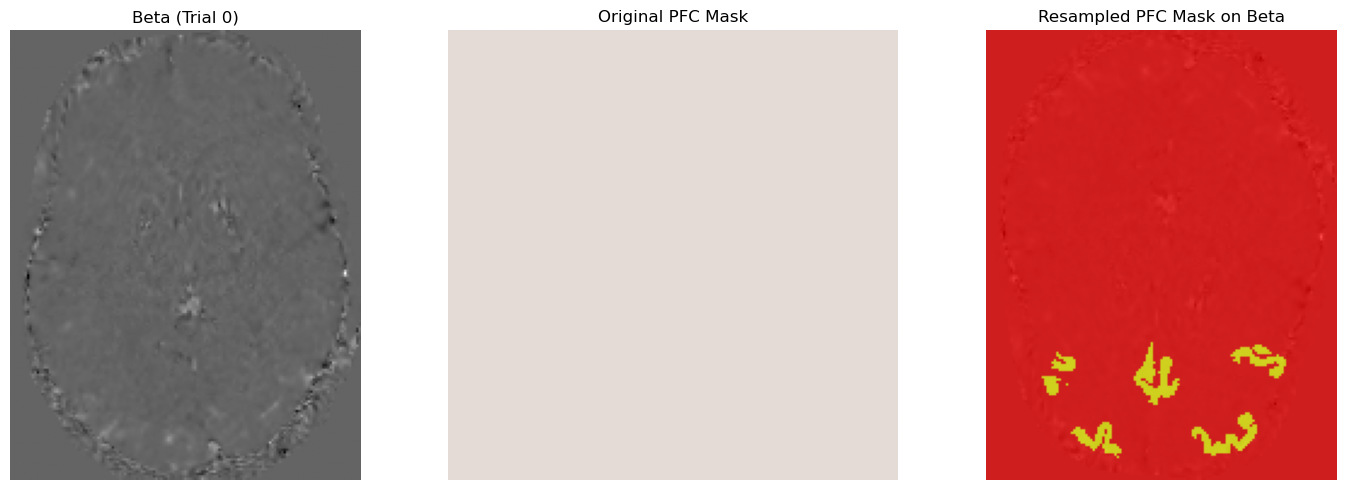

In [5]:
import matplotlib.pyplot as plt
from nilearn.image import resample_to_img
import numpy as np

# === Resample PFC mask to beta space ===
resampled_pfc = resample_to_img(pfc_img, beta_img, interpolation='nearest')

# === Print shape and affine ===
print("Resampled PFC shape:", resampled_pfc.shape)
print("Resampled PFC affine:\n", resampled_pfc.affine)

# === Choose a middle slice along z-axis ===
z_slice = beta_img.shape[2] // 2

# === Get image data ===
beta_data = beta_img.slicer[:, :, :, 0].get_fdata() / 300.0  # First beta trial
pfc_orig_data = pfc_img.get_fdata()
pfc_resamp_data = resampled_pfc.get_fdata()

# === Plot ===
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Panel 1: Beta image
axs[0].imshow(beta_data[:, :, z_slice].T, origin='lower', cmap='gray')
axs[0].set_title("Beta (Trial 0)")

# Panel 2: Original PFC mask (overlay on blank background for contrast)
axs[1].imshow(np.zeros_like(pfc_orig_data[:, :, z_slice].T), cmap='gray', origin='lower')
axs[1].imshow(pfc_orig_data[:, :, z_slice].T, cmap='Reds', alpha=0.9)
axs[1].set_title("Original PFC Mask")

# Panel 3: Resampled PFC mask over beta
axs[2].imshow(beta_data[:, :, z_slice].T, origin='lower', cmap='gray')
axs[2].imshow(pfc_resamp_data[:, :, z_slice].T, cmap='autumn', alpha=0.7)
axs[2].set_title("Resampled PFC Mask on Beta")

for ax in axs:
    ax.axis("off")

plt.tight_layout()
plt.show()
